In [1]:
# some global definitions
api_url = 'https://cmsweb.cern.ch/phedex/datasvc/json/prod/'

import urllib2
import json 
import time 
from glob import glob 
import sys 

class APIHandler(object):
  def __init__(self, which):
    self.api = which
    self.VERBOSE=False
    self.url = None
  def __call__(self, params):
    flags = ' --no-check-certificate ' + flags
    self.url = api_url + self.api + '?'
    param_strs = ['%s=%s'%(p, str(arg)) for p,arg in params.iteritems()]
    self.url += '&'.join(param_strs)
    if self.VERBOSE: print self.url 
    payload = json.load(urllib2.urlopen(self.url))['phedex']

    
import sqlite3
conn = sqlite3.connect('requests.sqlite')
cursor = conn.cursor()

print 'Done with setup'

Done with setup


In [34]:
# First, let's define some functions to query the history sources

def parse_record(path):
    with open(path,'r') as f:
        payload = json.load(f)['phedex']
    records = []
    for request in payload['request']:
        datasets = [(x['name'], x['bytes']) for x in request['data']['dbs']['dataset']]
        blocks = [(x['name'], x['bytes']) for x in request['data']['dbs']['block']]
        objs = datasets + blocks 
        user = request['requested_by']['name']
            
        for node in request['destinations']['node']:
            decided_by = node['decided_by']
            if not (decided_by['decision'] == 'y'):
                continue 
            site = node['name']
            timestamp = decided_by['time_decided']
            
            for obj in objs:
                if not obj[1]:
                    continue
                records.append((obj[0], int(obj[1]/1e6), site, user, int(timestamp)))
        
        return records
    
def create_table():
    cursor.execute('DROP TABLE IF EXISTS requests')
    cursor.execute('CREATE TABLE requests (object TEXT, size INTEGER, site TEXT, user TEXT, timestamp INTEGER)')
    
def insert_record(path):
    records = parse_record(path)
    cursor.executemany('INSERT INTO requests VALUES (?,?,?,?,?)', records)
    conn.commit()

In [31]:
# aggregate the data into a database
# SLOW - do not run this cell if the .sqlite is already there
if False:
    create_table()
    paths = glob('data/*')
    for i, path in enumerate(paths):
        if i%1000 == 0:
            print '%i/%i'%(i, len(paths))
        
        insert_record(path)
    conn.commit()
    

In [2]:
# make pretty plots!

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn
import matplotlib as mpl
import re
seaborn.set(style="ticks")
seaborn.set_context("poster")
mpl.rcParams['axes.linewidth'] = 1.25
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 9
plt.rcParams['figure.figsize'] = fig_size

# plot of requester over time 
requesters = [
              (re.compile('vocms[0-9]*.*'), 'vocms'), # I think this is T0
              ('Christoph Paus', 'DDM'),
              ('Jean-Roch Vlimant', 'PR'),
              ('dynamo Service', 'DDM'),
              ('Matteo Cremonsi', 'PR'),
              ('Andrew Michael Levin', 'PR'),
              ]
              
cmd = 'SELECT * FROM requests WHERE timestamp > 1456303261'
timestamps = {'other' : []}
sizes = {'other' : []}
for _, group in requesters:
    timestamps[group] = []
    sizes[group] = []
    
for x in cursor.execute(cmd):
    user = x[3]
    group = 'other'
    for k,v in requesters:
        if type(k) != str:
            if k.match(user):
                group = v
                break 
        elif k == user:
            group = v 
            break 
    timestamps[group].append(x[4])
    sizes[group].append(x[1])


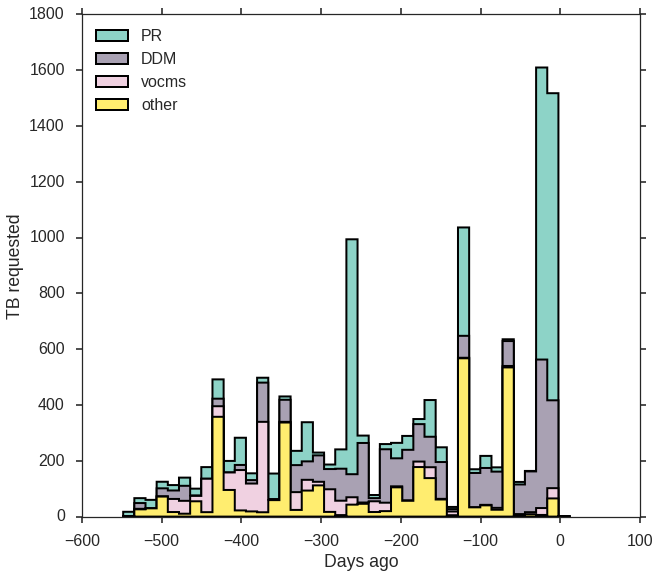

In [3]:
# make the actual plots 
import matplotlib.pylab as pl 
colors = pl.cm.Set3(np.linspace(0,1,4))

now = time.time()
bins = np.arange((1456303261 - now)/86400, 14, 14)
#colors = {'DDM':'r', 'PR':'b', 'vocms':'g', 'other':'k'}
cum_arr = np.array([],dtype=np.float32)
cum_w_arr = np.array([],dtype=np.float32)
arrs = {}
w_arrs = {}
order = ['PR','DDM', 'vocms', 'other']
order.reverse()
for group in order:
    t_arr = (np.array(timestamps[group]) - now)/86400
    cum_arr = np.concatenate([cum_arr, t_arr])
    s_arr = np.array(sizes[group]) / 1e6
    cum_w_arr = np.concatenate([cum_w_arr, s_arr])
    arrs[group] = cum_arr 
    w_arrs[group] = cum_w_arr
order.reverse()
plt.clf()
for i, group in enumerate(order):
    plt.hist(arrs[group], bins=bins, weights=w_arrs[group], 
             color=colors[i], histtype='stepfilled', linewidth=2,
             label=group)
plt.legend(loc=2)
plt.xlabel('Days ago')
plt.ylabel('TB requested')
plt.show()

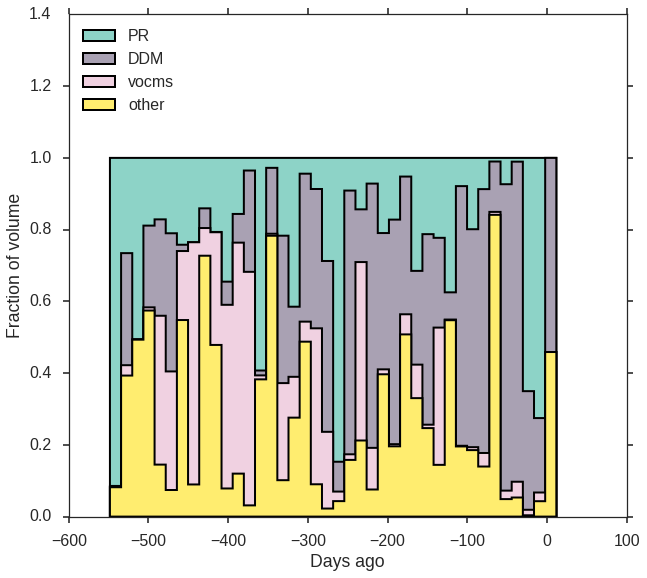

In [12]:
plt.clf()
content = {}
for i, group in enumerate(order):
    content[group] = np.histogram(arrs[group], bins=bins, weights=w_arrs[group])[0]
total = np.copy(content[order[0]])
for i, group in enumerate(order):
    content[group] /= total 
    plt.hist(bins[:-1], bins=bins, weights=content[group],
             color=colors[i], histtype='stepfilled', linewidth=2,
             label=group)
plt.legend(loc=2)
plt.xlabel('Days ago')
plt.ylabel('Fraction of volume')
plt.ylim((0,1.4))
plt.show()   

In [13]:
# plot of data tier over time 
            
cmd = 'SELECT * FROM requests WHERE timestamp > 1456303261'
tiers_ = ['^MINIAOD.*','^AOD.*','^GEN-SIM.*','^RAW$','^RECO$']
tiers = [re.compile(x) for x in tiers_]
tier_timestamps = {x : [] for x in tiers+['other']}
tier_sizes = {x : [] for x in tiers+['other']}
others = {}
for x in cursor.execute(cmd):
    obj = x[0]
    tier = obj.split('/')[-1].split('#')[0]
    cat = 'other'
    for pattern in tiers:
        if pattern.match(tier):
            cat = pattern 
            break 
    tier_timestamps[cat].append(x[4])
    tier_sizes[cat].append(x[1])
print sorted(others.items(), key=lambda x : x[1])

[]


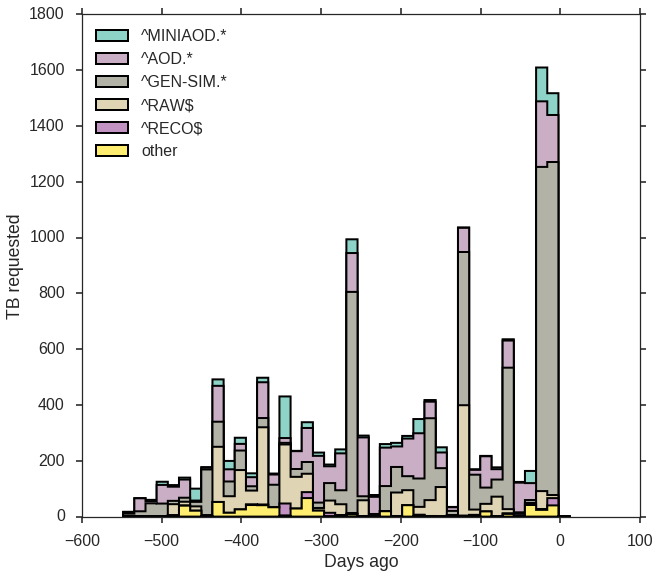

In [14]:
colors = pl.cm.Set3(np.linspace(0,1,len(tiers)+1))

now = time.time()
bins = np.arange((1456303261 - now)/86400, 14, 14)
cum_arr = np.array([],dtype=np.float32)
cum_w_arr = np.array([],dtype=np.float32)
arrs = {}
w_arrs = {}
order = tiers[:]+['other']
order.reverse()
for group in order:
    t_arr = (np.array(tier_timestamps[group]) - now)/86400
    cum_arr = np.concatenate([cum_arr, t_arr])
    s_arr = np.array(tier_sizes[group]) / 1e6
    cum_w_arr = np.concatenate([cum_w_arr, s_arr])
    arrs[group] = cum_arr 
    w_arrs[group] = cum_w_arr
order.reverse()
plt.clf()
for i, (group, label) in enumerate(zip(order,tiers_+['other'])):
    plt.hist(arrs[group], bins=bins, weights=w_arrs[group], 
             color=colors[i], histtype='stepfilled', linewidth=2,
             label=label)
plt.legend(loc=2)
plt.xlabel('Days ago')
plt.ylabel('TB requested')
plt.show()

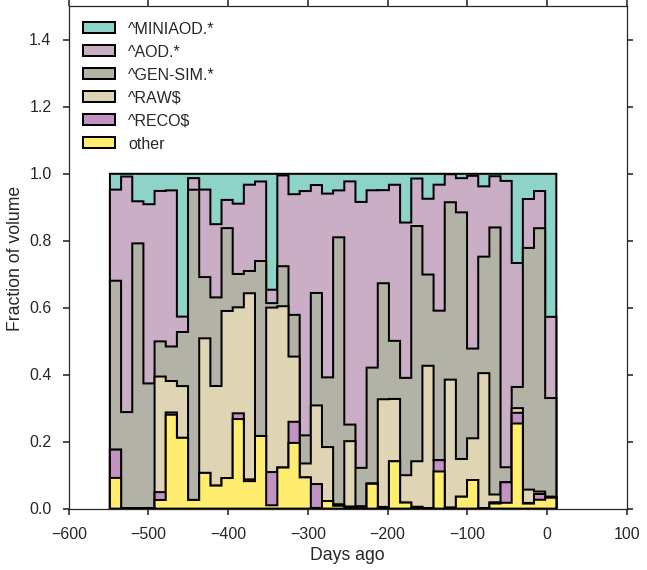

In [17]:
plt.clf()
content = {}
for i, group in enumerate(order):
    content[group] = np.histogram(arrs[group], bins=bins, weights=w_arrs[group])[0]
total = np.copy(content[order[0]])
for i, (group, label) in enumerate(zip(order,tiers_+['other'])):
    content[group] /= total 
    plt.hist(bins[:-1], bins=bins, weights=content[group],
             color=colors[i], histtype='stepfilled', linewidth=2,
             label=label)
plt.legend(loc=2)
plt.xlabel('Days ago')
plt.ylabel('Fraction of volume')
plt.ylim((0,1.5))
plt.show()   